# Theoretical Transition Matrix

Trying to match theoretical transition matrix with observed matrix. This draws off work from theoretical_transition_matrix_Copy210202

In [11]:
# from abinitio_tm import abinitio 
import numpy as np
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import * 
from vcf_mhs import *
import argparse
from matplotlib.patches import Rectangle
import pdb



# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# this script generates a tm as per Schiffels' equations - i.e. these are the theoretical transition probabilities

import math
import numpy as np
import pdb

def corrected_abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
                pre = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) 
#                 print('with L(alpha)^2 = {} and H_i(alpha) = {} and H_alpha(alpha)= {}'.format(L(T[alpha+1],T[alpha])**2,(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T))),(1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha)))))
                B = (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
#                 print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
                pre = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = q_2_sum2(beta)
                B = (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
#                 print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))

        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

# this heatmap works well for values between -1 and 1
def heatmaps_div_patch(matrix,title='',patch=[1,1]):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax.add_patch(Rectangle((0, patch[0]), len(matrix), patch[1], fill=False, edgecolor='black', lw=2))
#     ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None


In [116]:
def structuredsplit_abinitio(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):
    # written 210213ymd
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    def sigma(int):
        sig = (1-gamma_array[int])**2 + (gamma_array[int])**2
        return sig
    def psis_finder(gamma_array):
        # find the first change in gamma (psi_s) and last change in gamma (psi_e)
        # for now, assume there is only one period of structure
        try:
            psi_s = np.where(gamma_array!=1)[0][0]
            psi_e = np.where(gamma_array!=1)[0][-1]
        except:
            psi_e = None
            psi_s = None
#             print('Psi is None')
        return psi_s, psi_e
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L
    
    def G(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:            
            time = np.array([time1,time2])
            G_upperlower = np.array([None,None]) # store as [G_lower,G_upper]
            for j in range(0,2):
                if time[j] >= T[psi_e+1]:
                    sig = sigma(psi_s)
                    G_upperlower[j] = L(0,T_np[psi_s])*(1-sig + sig*L(T_np[psi_s],T_np[psi_e-7]))*L(T_np[psi_e-7],time[j])
                else:
                    G_upperlower[j] = L(0,time[j])
            G = G_upperlower[1]/G_upperlower[0] # G = G_upper/G_lower
        return G
    
# flagqqq

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (sigma(alpha)**2)* (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (G(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (sigma(alpha)**1)* (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

def structuredsplit_abinitio_plain(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):
    # written 210223ymd
    # just uses G = L(time1,time2)**2 everywhere
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    def sigma(int):
        sig = (1-gamma_array[int])**2 + (gamma_array[int])**2
        return sig
    def psis_finder(gamma_array):
        # find the first change in gamma (psi_s) and last change in gamma (psi_e)
        # for now, assume there is only one period of structure
        try:
            psi_s = np.where(gamma_array!=1)[0][0]
            psi_e = np.where(gamma_array!=1)[0][-1]
        except:
            psi_e = None
            psi_s = None
#             print('Psi is None')
        return psi_s, psi_e
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L
    
    def G(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:            
            time = np.array([time1,time2])
            G_upperlower = np.array([None,None]) # store as [G_lower,G_upper]
            for j in range(0,2):
                if time[j] >= T[psi_e+1]:
                    sig = sigma(psi_s)
                    G_upperlower[j] = L(0,T_np[psi_s])*(1-sig + sig*L(T_np[psi_s],T_np[psi_e-7]))*L(T_np[psi_e-7],time[j])
                else:
                    G_upperlower[j] = L(0,time[j])
            G = G_upperlower[1]/G_upperlower[0] # G = G_upper/G_lower
        return G
    
# flagqqq

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (G(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (sigma(alpha)**1)* (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_


In [48]:
time = np.array([None,None])
print(time)
time[0]=34
print(time)
time[1] = 27
print(time)

[None None]
[34 None]
[34 27]


In [4]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

print(f'T_np is {T_np}\n\n')
print(f'T_scaled_np is {T_scaled_np}')

T_np is [0.         0.03678794 0.04090434 0.04548135 0.0505705  0.05622911
 0.06252089 0.06951668 0.07729528 0.08594426 0.09556103 0.10625386
 0.11814318 0.13136285 0.14606175 0.16240538 0.18057779 0.20078361
 0.22325037 0.24823105 0.27600695 0.30689085 0.34123052 0.37941263
 0.42186715 0.46907213 0.52155912 0.57991917 0.64480944 0.71696063
 0.79718521 0.88638654 0.98556909 1.0958497  1.21847021 1.35481138
 1.5064085  1.67496864 1.86238987 2.07078267 2.30249366 2.56013204
 2.84659895 3.16512019 3.51928248 3.91307389 4.35092873 4.83777751
 5.3791024  5.98099905 6.65024514]


T_scaled_np is [     0.            735.75888234    818.08689348    909.62702774
   1011.41007904   1124.58218235   1250.41771984   1390.33367116
   1545.90556937   1718.88524244   1911.22053974   2125.07726597
   2362.86356935   2627.25705872   2921.23495497   3248.1076162
   3611.55581425   4015.67218228   4465.00730015   4964.62093654
   5520.13902479   6137.81701413   6824.61030959   7588.2525938
   8437.34291267

In [5]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

def const_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def psc_pop(seq_length,T_1 = 15000,T_2=26500):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_A*2,growth_rate=0),
        msprime.PopulationParametersChange(time=T_2, initial_size=N_A,growth_rate=0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def split(N,mig_prop,T_1,T_2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

def split2(N,mig_prop,T_1,T_2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=0, dest=1, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=50,type=int)
parser.add_argument("-N_T","--Number_of_states",help="The number of states you want, for the time intervals (Default is 50)",default=50,type=int)
args = parser.parse_args("m0001".split())

## Panmictic population of changing size

In [7]:
N_0 = 10000
T1_ind = 30
T2_ind = 40
T_1 = T_np[T1_ind]*2*N_0
T_2 = T_np[T2_ind]*2*N_0
print('T_1 and T_2 are {}'.format([T_1,T_2]))
sim1 = psc_pop(150e+06,T_1=T_1,T_2=T_2)
print('simulation finished')

T_1 and T_2 are [15943.704151042171, 46049.87318513843]
Model =  hudson(reference_size=1)
Epoch: 0 -- 15943.704151042171 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 15943.704151042171
   - Population parameter change for -1: initial_size -> 20000 growth_rate -> 0 
Epoch: 15943.704151042171 -- 46049.87318513843 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 46049.87318513843
   - Population parameter change for -1: initial_size -> 10000 growth_rate -> 0 
Epoch: 46049.87318513843 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

simulation finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


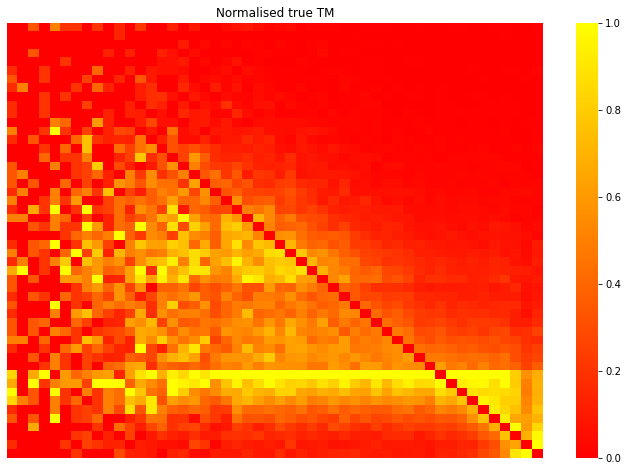

In [12]:
tmrca_data1 = get_coal_data(sim1, args) # get true coalescent 
coal_times_absolute1 = round_bin_coal_data(sim1.sequence_length,tmrca_data1, args) # partition coalescent data into bins  
coal_times1 = coal_times_absolute1 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals1 = round_coal_times(coal_times1,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm1 = tm_counts(coal_times_intervals1,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd1 = np.copy(tm1)
tm_nd1[range(0,len(tm1)),range(0,len(tm1))] = 0
tm_nd_norm1 = normalise(tm_nd1,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd1,'colmax'),title='Normalised true TM') # show heatmap


Does panmictic theory fit the data?

In [13]:
pop_size1 = [1*10000 for i in range(0,N_T)]
pop_size1 = np.array(pop_size1)
pop_size1[T1_ind:T2_ind] = 20000
print('pop_size1 is {}'.format(pop_size1))

pop_size1 is [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000 10000 10000 10000 10000 20000 20000 20000 20000 20000 20000
 20000 20000 20000 20000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000]


In [14]:
q_2_A, q_2_upper_A, q_2_lower_A, q_1_A, q_A = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# heatmaps_seq(normalise(q_2_A,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap


pop_size is [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000 10000 10000 10000 10000 20000 20000 20000 20000 20000 20000
 20000 20000 20000 20000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


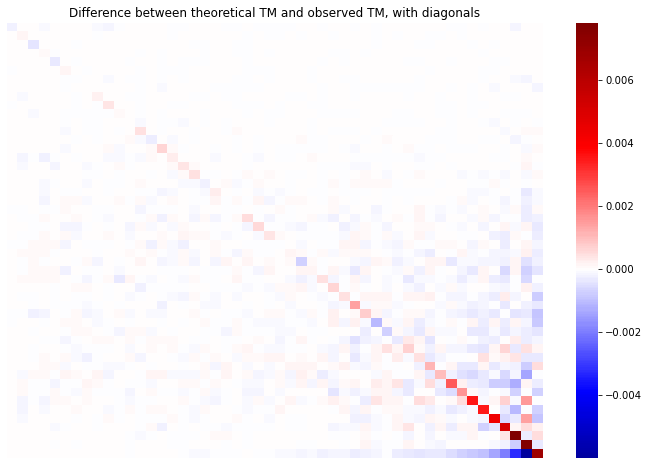

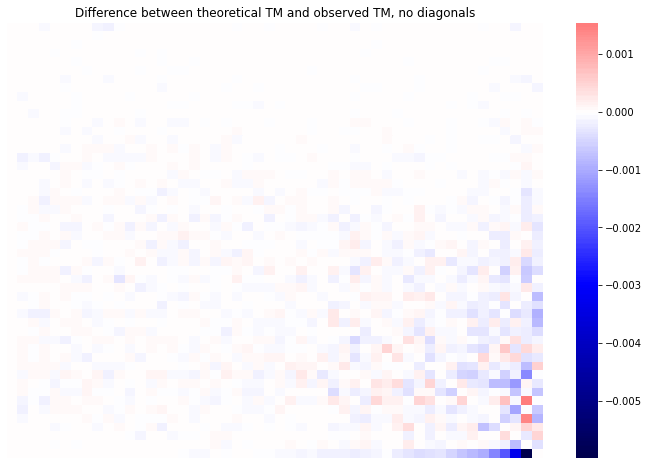

In [54]:
tm_1 = normalise(tm1,'colsum')
diff_1A = q_A - tm_1
diff_1A_nd = np.copy(diff_1A)
diff_1A_nd = remove_diagonals(diff_1A_nd)

heatmaps_div(diff_1A,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_1A_nd,title="Difference between theoretical TM and observed TM, no diagonals")


Looks quite good - nothing systemtically wrong. 

Now check with structuredsplit_abinitio()

In [15]:
gamma_array = np.array([1 for i in range(0,N_T)],np.float)
print('gamma_array is {}'.format(gamma_array))

gamma_array is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [17]:
q_2_B, q_2_upper_B, q_2_lower_B, q_1_B, q_B = structuredsplit_abinitio(T_np,50,pop_size1,gamma_array,N_0,r=2e-08*args.bin_length)
# heatmaps_seq(normalise(q_2_A,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap


pop_size is [10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000 10000 10000 10000 10000 20000 20000 20000 20000 20000 20000
 20000 20000 20000 20000 10000 10000 10000 10000 10000 10000 10000 10000
 10000 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


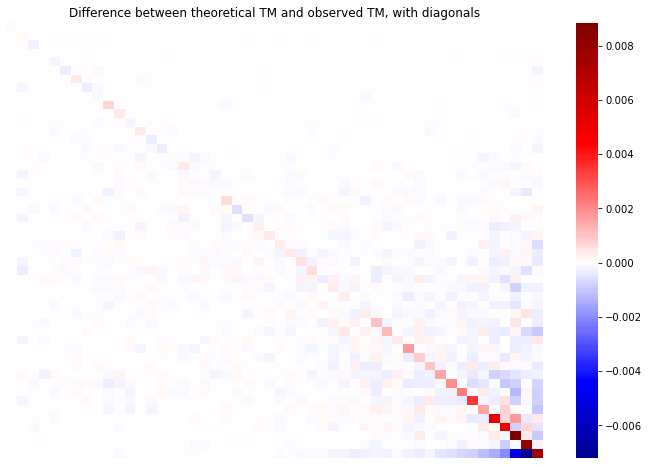

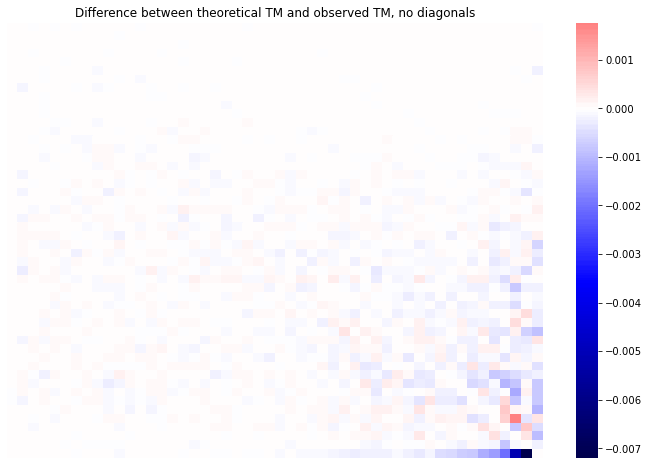

In [18]:
tm_1 = normalise(tm1,'colsum')
diff_1B = q_B - tm_1
diff_1B_nd = np.copy(diff_1B)
diff_1B_nd = remove_diagonals(diff_1B_nd)

heatmaps_div(diff_1B,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_1B_nd,title="Difference between theoretical TM and observed TM, no diagonals")


Looks ok to me - this is using structuredsplit_abinitio (with no structure) to match panmictic population size change. 

# Split population (structure) of constant size

In [37]:
N_0 = 10000
T1_ind = 30
T2_ind = 40
T_1 = T_np[T1_ind]*2*N_0
T_2 = T_np[T2_ind]*2*N_0
gamma = 0.2
seq_length=150e+06
print('T_1 and T_2 are {}'.format([T_1,T_2]))
print('gamma is {}'.format(gamma))
sim2 = split(N_0,gamma,T_1,T_2,seq_length)

T_1 and T_2 are [15943.704151042171, 46049.87318513843]
gamma is 0.2
N is 10000
mig_prop is 0.2
t_1 is 15943.704151042171 and t_2 is 46049.87318513843
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 15943.704151042171 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 15943.704151042171
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 15943.704151042171 -- 46049.87318513843 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


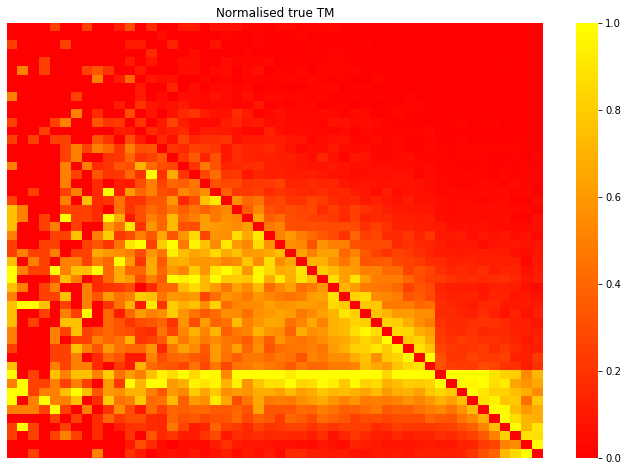

In [38]:
tmrca_data2 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute2 = round_bin_coal_data(sim2.sequence_length,tmrca_data2, args) # partition coalescent data into bins  
coal_times2 = coal_times_absolute2 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2 = round_coal_times(coal_times2,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2 = tm_counts(coal_times_intervals2,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2 = np.copy(tm2)
tm_nd2[range(0,len(tm2)),range(0,len(tm2))] = 0
tm_nd_norm2 = normalise(tm_nd2,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2,'colmax'),title='Normalised true TM') # show heatmap


In [51]:
pop_size2 = [1*10000 for i in range(0,N_T)]
# pop_size1 = np.array(pop_size1)
# pop_size1[T1_ind:T2_ind] = 20000
print('pop_size2 is {}'.format(pop_size2))

gamma_array2 = np.array([1 for i in range(0,N_T)],np.float)
gamma_array2[T1_ind:T2_ind] = 0.2

print('gamma_array2 is {}'.format(gamma_array2))


pop_size2 is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
gamma_array2 is [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]


pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


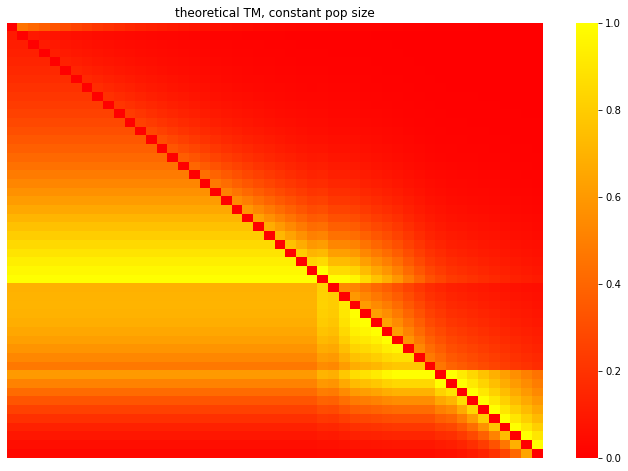

In [52]:
q_2_B, q_2_upper_B, q_2_lower_B, q_1_B, q_B = structuredsplit_abinitio(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2_B,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.5185070622948836


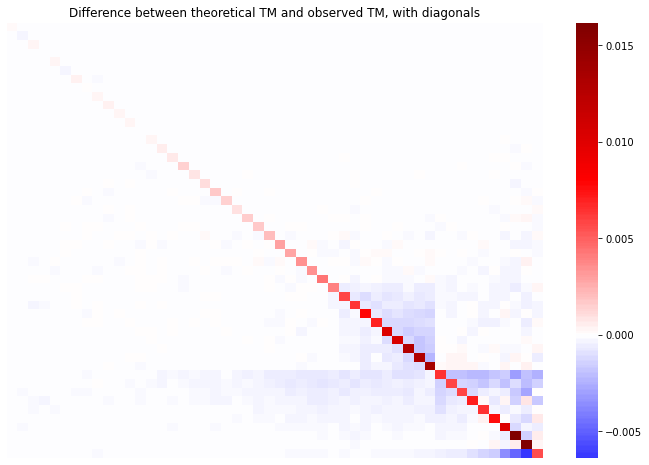

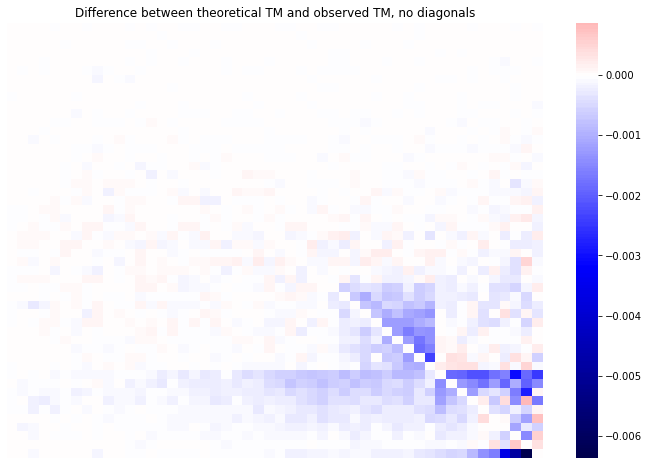

In [53]:
tm_2 = normalise(tm2,'colsum')
diff_2B = q_B - tm_2
diff_2B_nd = np.copy(diff_2B)
diff_2B_nd = remove_diagonals(diff_2B_nd)

heatmaps_div(diff_2B,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2B_nd,title="Difference between theoretical TM and observed TM, no diagonals")

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2B)).sum()))


In [54]:
sum(abs(diff_2B)).sum()

0.5185070622948836

# Split population (structure) of constant size try 2

In [41]:
N_0 = 10000
T1_ind = 25
T2_ind = 35
T_1 = T_np[T1_ind]*2*N_0
T_2 = T_np[T2_ind]*2*N_0
gamma = 0.3
seq_length=150e+06
print('T_1 and T_2 are {}'.format([T_1,T_2]))
print('gamma is {}'.format(gamma))
sim2b = split(N_0,gamma,T_1,T_2,seq_length)

T_1 and T_2 are [9381.442505494031, 27096.22767576434]
gamma is 0.3
N is 10000
mig_prop is 0.3
t_1 is 9381.442505494031 and t_2 is 27096.22767576434
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 9381.442505494031 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 9381.442505494031
   - Mass migration: Lineages moved with probability 0.3 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 9381.442505494031 -- 27096.22767576434 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


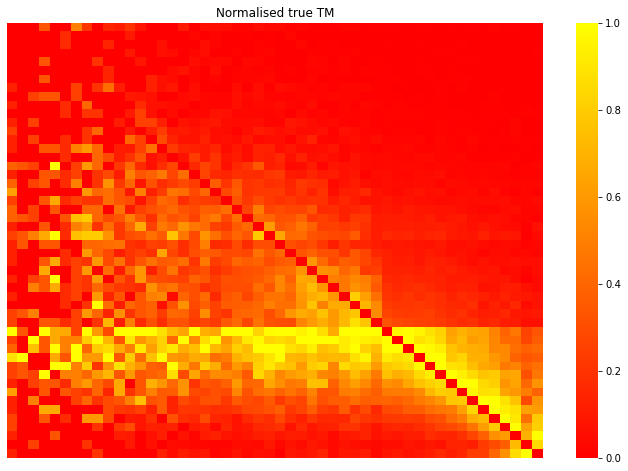

In [93]:
tmrca_data2b = get_coal_data(sim2b, args) # get true coalescent 
coal_times_absolute2b = round_bin_coal_data(sim2b.sequence_length,tmrca_data2b, args) # partition coalescent data into bins  
coal_times2b = coal_times_absolute2b #/(2be+04) # divide by 2bN_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2b = round_coal_times(coal_times2b,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2b = tm_counts(coal_times_intervals2b,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2b = np.copy(tm2b)
tm_nd2b[range(0,len(tm2b)),range(0,len(tm2b))] = 0
tm_nd_norm2b = normalise(tm_nd2b,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2b,'colmax'),title='Normalised true TM') # show heatmap


In [94]:
pop_size2 = [1*10000 for i in range(0,N_T)]
# pop_size1 = np.array(pop_size1)
# pop_size1[T1_ind:T2_ind] = 20000
print('pop_size2 is {}'.format(pop_size2))

gamma_array2 = np.array([1 for i in range(0,N_T)],np.float)
gamma_array2[T1_ind:T2_ind] = 0.3

print('gamma_array2 is {}'.format(gamma_array2))


pop_size2 is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
gamma_array2 is [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]


In [95]:
T2_ind
# flag 23feb

35

pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


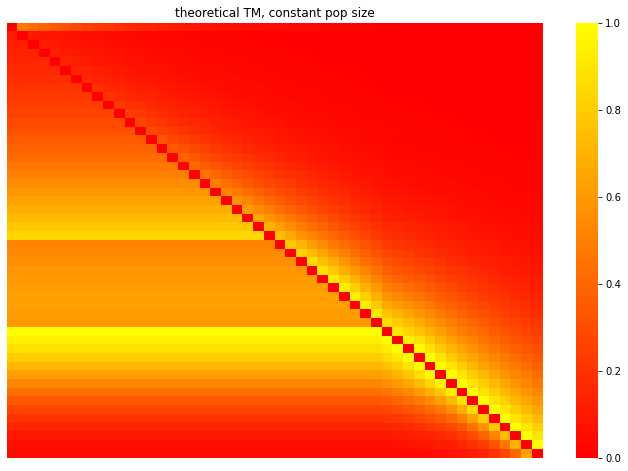

In [114]:
 # structuredsplit_abinitio_plain uses just G = L(time,time2)**2 everywhere
q_2_Bb, q_2_upper_Bb, q_2_lower_Bb, q_1_Bb, q_Bb = structuredsplit_abinitio_plain(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2_Bb,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.47228430913513003


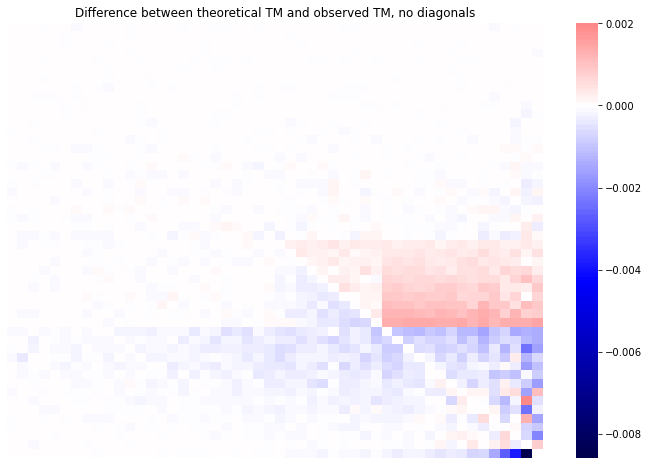

In [115]:
tm_2b = normalise(tm2b,'colsum')
diff_2Bb = q_Bb - tm_2b # theory minus observations
diff_2Bb_nd = np.copy(diff_2Bb)
diff_2Bb_nd = remove_diagonals(diff_2Bb_nd)

# heatmaps_div(diff_2Bb,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2Bb_nd,title="Difference between theoretical TM and observed TM, no diagonals")
# heatmaps_div_patch(diff_2Bb_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[20,17])

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2Bb)).sum()))


In [960]:
# for some matrix of size [NxN], N[i,j] means i'th row and j'th column

### Try a different approach


Written 23rd feb 0949. Use structuredsplit_abinitio_new as defined at the top, where we have G = L^2 (plain case) but add in sigma^2 as a coeffeciient to everything else

In [117]:
q_2_C, q_2_upper_C, q_2_lower_C, q_1_C, q_C = structuredsplit_abinitio_new(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
# heatmaps_seq(normalise(q_2_C,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.42724803099624403


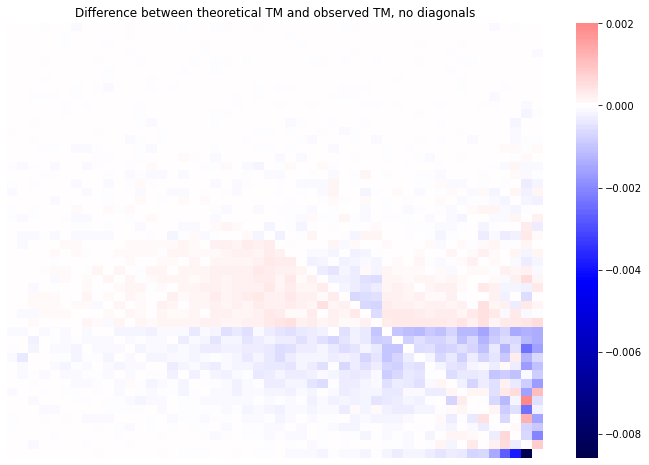

In [118]:
tm_2b = normalise(tm2b,'colsum')
diff_2C = q_C - tm_2b # theory minus observations
diff_2C_nd = np.copy(diff_2C)
diff_2C_nd = remove_diagonals(diff_2C_nd)

# heatmaps_div(diff_2C,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2C_nd,title="Difference between theoretical TM and observed TM, no diagonals")
# heatmaps_div_patch(diff_2C_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[20,17])

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2C)).sum()))


### Try again

210217ymd. Working case by case, see my notepad or the same date. 

In [65]:
def structuredsplit_abinitio_new(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):
    # written 210217ymd
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    def sigma(int):
        sig = (1-gamma_array[int])**2 + (gamma_array[int])**2
        return sig
    def psis_finder(gamma_array):
        # find the first change in gamma (psi_s) and last change in gamma (psi_e)
        # for now, assume there is only one period of structure
        try:
            psi_s = np.where(gamma_array!=1)[0][0]
            psi_e = np.where(gamma_array!=1)[0][-1]
        except:
            psi_e = None
            psi_s = None
#             print('Psi is None')
        return psi_s, psi_e
    
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2

    def L(time1,time2):
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if ind1 == ind2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(T[ind1+1] - time1)*lambda_(ind1) - sum - (time2 - T[ind2])*lambda_(ind2))
        return L

    # flaggg
    
    def G(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            G = L(time1,time2)
        return G
    
    def G_B(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            sig = sigma(ind2)
            G = L(time1,time2)
        return G
    
    def G_C(time1,time2): # case C; bottom right corner
        # for when upper interval is higher than last structure occurence
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_e+1]:
            print('misunderstanding!')
        ind1, ind2 = lower_higher_intervals(time1,time2)
        sig = sigma(psi_s)
        gamma = gamma_array[psi_s]
        guess = 1
        if time1>=T[psi_e+1]:
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time1)
            G = G_upper/G_lower
            return G 
        elif time1>=T[psi_s] and time1<T[psi_e+1]:
#             G = ( (gamma)*L(time1,T[psi_e+guess]) + (1-gamma)*L(time1,T[psi_e+guess]) + 2*gamma*(1-gamma)) * L(T[psi_e+guess],time2) 
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],time1))
            G = G_upper/G_lower
            return G
        elif time1<T[psi_s]:
#             G = L(time1,T[psi_s]) * ( (gamma)*L(T[psi_s],T[psi_e+guess]) + (1-gamma)*L(T[psi_s],T[psi_e+guess]) + 2*gamma*(1-gamma)) * L(T[psi_e+guess],time2) 
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,time1)
            G = G_upper/G_lower
            return G
        else:
            print('there has been an error in G_post!')
        return G

    def G_4(time1,time2): # case 4, structured time to structured time
        # time2 necessarily will have time2>psi_s and time2<psi_e+1
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_s] or time2>T[psi_e+1]:
            print('problem! Misunderstanding in G_4')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*(
                    (gamma**2)*(L(T[psi_s],time2)**2) + ((1-gamma)**2)*(L(T[psi_s],time2)**2)
                )
#                 G = L(time1,T[psi_s])*((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))            
            elif time1>=T[psi_s]:
                G = ((gamma)**2)*(L(time1,time2)**2) + (((1-gamma)**2)*(L(time1,time2)**2)) 
#                 G = ((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))
        return G
    
    def H_4(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))
        else:
            print('misunderstanding in H_4!')
        return H
    
    def J_4(ind):
        J = (1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def G_5(time1,time2): # case 5, post structured time to structured time
        # time2 necessarily will have time2>psi_e
        psi_s, psi_e = psis_finder(gamma_array)
        if time2>=T[psi_e+1] or time2<T[psi_s]:
            print(f'problem! Misunderstanding in G_5. time 2 is {time2}, T[psi_s] is {T[psi_s]} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)**2
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*(
                    (gamma**2)*(L(T[psi_s],time2)**2) + ((1-gamma)**2)*(L(T[psi_s],time2)**2)
                )
#                 G = L(time1,T[psi_s])*((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))            
            elif time1>=T[psi_s]:
                G = ((gamma)**2)*(L(time1,time2)**2) + (((1-gamma)**2)*(L(time1,time2)**2)) 
#                 G = ((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))
        return G
    
    def H_5(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))
        else:
            print('misunderstanding in H_5!')
        return H
    
    def J_5(ind):
        J = (1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def G_6(time1,time2): # case 6, post structured time to post structured time
        # time2 necessarily will have time2>psi_e 
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_e+1]:
            print(f'problem! Misunderstanding in G_6. time 2 is {time2}, T[psi_s] is {T[psi_s]} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*( (gamma**2)*(L(T[psi_s],T[psi_e+1])**2) + ((1-gamma)**2)*(L(T[psi_s],T[psi_e+1])**2) )*(L(T[psi_e+1],time2)**2)
#                 G = L(time1,T[psi_s])*((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))            
            elif time1>=T[psi_s] and time1<T[psi_e+1]:
                G = ((gamma**2)*(L(time1,T[psi_e+1])**2) + ((1-gamma)**2)*(L(time1,T[psi_e+1])**2) )*(L(T[psi_e+1],time2)**2)
#                 G = ((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))
            elif time1>=T[psi_e+1]:
                G = (L(time1,time2))**2
            else:
                print('Misunderstanding in G_6 !')
        return G
    
    
    def H_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s or ind>=psi_e+1:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s and ind<psi_e+1:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))
        else:
            print('misunderstanding in H_6!')
        return H
    
    def J_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        J = (1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper4(alpha): # case A
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_4(j)*(G_4(T[j+1],T[alpha]))
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upper5(alpha): # case A
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_5(j)*(G_5(T[j+1],T[alpha]))
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper6(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_6(j)*(G_6(T[j+1],T[alpha]))
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperB(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_B(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperC(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_C(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                psi_s,psi_e = psis_finder(gamma_array)

                
                if alpha>=(psi_s) and alpha<=(psi_e+1) and beta>(psi_s) and beta<=(psi_e+1): # case 4, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * ( ((gamma)**2)*lambda_(alpha) + ((1-gamma)**2)*lambda_(alpha) )  * (
                        q_2_upper4(alpha)*H_4(alpha) + J_4(alpha)
                                )
#                     q_2[alpha,beta] = 100                   

                elif alpha>=(psi_s) and alpha<(psi_e+1) and beta>=(psi_e+1): # case 5, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * ( ((gamma)**2)*lambda_(alpha) + ((1-gamma)**2)*lambda_(alpha) ) * ( # sometimes multiplying by sigma(alpha)**2 works well
                        q_2_upper5(alpha)*H_5(alpha) + J_5(alpha)
                                )
#                     q_2[alpha,beta] = 100

                elif alpha>=(psi_e+1) and beta>=(psi_e+1): # case 6; bottom right corner NEW
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                         q_2_upper6(alpha)*H_6(alpha) + J_6(alpha)
                                )
#                     q_2[alpha,beta] = 100

                else: # case 1, 2, or 3
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )       
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (G(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
#                 q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (sigma(alpha)**1)* (
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) *  (                  
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_


pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


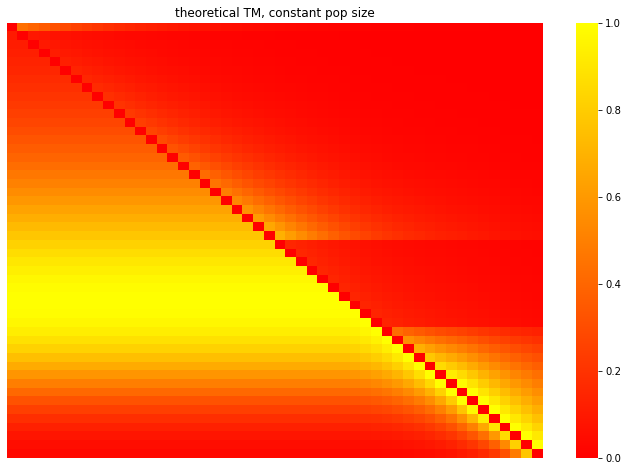

In [66]:
q_2_D, q_2_upper_D, q_2_lower_D, q_1_D, q_D = structuredsplit_abinitio_new(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2_D,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.7958641613232631


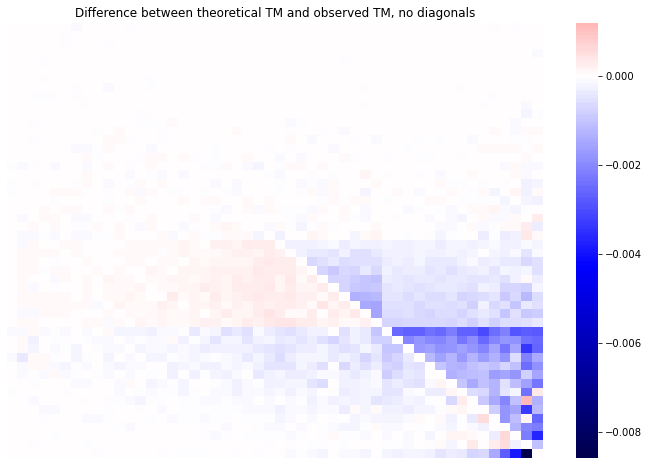

In [67]:
tm_2b = normalise(tm2b,'colsum')
diff_2D = q_D - tm_2b # theory minus observations
diff_2D_nd = np.copy(diff_2D)
diff_2D_nd = remove_diagonals(diff_2D_nd)

# heatmaps_div(diff_2D,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2D_nd,title="Difference between theoretical TM and observed TM, no diagonals")
# heatmaps_div_patch(diff_2D_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[20,17])

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2D)).sum()))


#### Try again
210219ymd

In [68]:
def structuredsplit_abinitio_new(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):
    # written 210217ymd
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    def sigma(int):
        sig = (1-gamma_array[int])**2 + (gamma_array[int])**2
        return sig
    def psis_finder(gamma_array):
        # find the first change in gamma (psi_s) and last change in gamma (psi_e)
        # for now, assume there is only one period of structure
        try:
            psi_s = np.where(gamma_array!=1)[0][0]
            psi_e = np.where(gamma_array!=1)[0][-1]
        except:
            psi_e = None
            psi_s = None
#             print('Psi is None')
        return psi_s, psi_e
    
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2

    def L(time1,time2):
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if ind1 == ind2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(T[ind1+1] - time1)*lambda_(ind1) - sum - (time2 - T[ind2])*lambda_(ind2))
        return L

    # flaggg
    
    def G(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            G = L(time1,time2)
        return G
    
    def G_B(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            sig = sigma(ind2)
            G = L(time1,time2)
        return G
    
    def G_C(time1,time2): # case C; bottom right corner
        # for when upper interval is higher than last structure occurence
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_e+1]:
            print('misunderstanding!')
        ind1, ind2 = lower_higher_intervals(time1,time2)
        sig = sigma(psi_s)
        gamma = gamma_array[psi_s]
        guess = 1
        if time1>=T[psi_e+1]:
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time1)
            G = G_upper/G_lower
            return G 
        elif time1>=T[psi_s] and time1<T[psi_e+1]:
#             G = ( (gamma)*L(time1,T[psi_e+guess]) + (1-gamma)*L(time1,T[psi_e+guess]) + 2*gamma*(1-gamma)) * L(T[psi_e+guess],time2) 
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],time1))
            G = G_upper/G_lower
            return G
        elif time1<T[psi_s]:
#             G = L(time1,T[psi_s]) * ( (gamma)*L(T[psi_s],T[psi_e+guess]) + (1-gamma)*L(T[psi_s],T[psi_e+guess]) + 2*gamma*(1-gamma)) * L(T[psi_e+guess],time2) 
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,time1)
            G = G_upper/G_lower
            return G
        else:
            print('there has been an error in G_post!')
        return G

    def G_4(time1,time2): # case 4, structured time to structured time
        # time2 necessarily will have time2>psi_s and time2<psi_e+1
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_s] or time2>T[psi_e+1]:
            print('problem! Misunderstanding in G_4')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s]))*(
                    (gamma**2)*(L(T[psi_s],time2)) + ((1-gamma)**2)*(L(T[psi_s],time2))
                )
#                 G = L(time1,T[psi_s])*((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))            
            elif time1>=T[psi_s]:
                G = ((gamma)**2)*(L(time1,time2)) + (((1-gamma)**2)*(L(time1,time2))) 
#                 G = ((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))
        G = L(time1,time2)
        return G
    
    def H_4(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
#             H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
            
        else:
            print('misunderstanding in H_4!')
        return H
    
    def J_4(ind):
#         J = (1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        J = (1/(2*lambda_(ind)))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def G_5(time1,time2): # case 5, post structured time to structured time
        # time2 necessarily will have time2>psi_e
        psi_s, psi_e = psis_finder(gamma_array)
        if time2>=T[psi_e+1] or time2<T[psi_s]:
            print(f'problem! Misunderstanding in G_5. time 2 is {time2}, T[psi_s] is {T[psi_s]} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s]))*(
                    (gamma**2)*(L(T[psi_s],time2)) + ((1-gamma)**2)*(L(T[psi_s],time2))
                )
#                 G = L(time1,T[psi_s])*((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))            
            elif time1>=T[psi_s]:
                G = ((gamma)**2)*(L(time1,time2)) + (((1-gamma)**2)*(L(time1,time2))) 
#                 G = ((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))
        G = L(time1,time2) # deletethis
        return G
    
    def H_5(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))
        else:
            print('misunderstanding in H_5!')
        H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind))) # delete this
        return H
    
    def J_5(ind):
#         J = (1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        J = (1/(2*lambda_(ind)))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))  
        return J
    
    def G_6(time1,time2): # case 6, post structured time to post structured time
        # time2 necessarily will have time2>psi_e 
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_e+1]:
            print(f'problem! Misunderstanding in G_6. time 2 is {time2}, T[psi_s] is {T[psi_s]} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                sigma = gamma**2 + (1-gamma)**2
                G = L(time1,time2)
            elif time1>=T[psi_s] and time1<T[psi_e+1]:
                G = ((gamma**2)*(L(time1,T[psi_e+1])**2) + ((1-gamma)**2)*(L(time1,T[psi_e+1])**2) )*(L(T[psi_e+1],time2)**2)
#                 G = ((gamma**2)*L(T[psi_s],time2) + ((1-gamma)**2)*L(T[psi_s],time2))
                sigma = gamma**2 + (1-gamma)**2
                G = L(time1,time2)
            elif time1>=T[psi_e+1]:
                G = (L(time1,time2))
            else:
                print('Misunderstanding in G_6 !')
        return G
    
    
    def H_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s or ind>=psi_e+1:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s and ind<psi_e+1:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        else:
            print('misunderstanding in H_6!')
        return H
    
    def J_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        J = (1/(2*lambda_(ind)))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper4(alpha): # case A
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_4(j)*(G_4(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upper5(alpha): # case A
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_5(j)*(G_5(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper6(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_6(j)*(G_6(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperB(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_B(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperC(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_C(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                psi_s,psi_e = psis_finder(gamma_array)

                
                if alpha>=(psi_s) and alpha<=(psi_e+1) and beta>(psi_s) and beta<=(psi_e+1): # case 4, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) *(sigma(alpha))*lambda_(alpha)  * (
                        q_2_upper4(alpha)*H_4(alpha) + J_4(alpha)
                                )
#                     q_2[alpha,beta] = 100                   

                elif alpha>=(psi_s) and alpha<(psi_e+1) and beta>=(psi_e+1): # case 5, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * (sigma(alpha)) * (lambda_(alpha)) * ( # sometimes multiplying by sigma(alpha)**2 works well
                        q_2_upper5(alpha)*H_5(alpha) + J_5(alpha)
                                )
#                     q_2[alpha,beta] = 100

                elif alpha>=(psi_e+1) and beta>=(psi_e+1): # case 6; bottom right corner NEW
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                         q_2_upper6(alpha)*H_6(alpha) + J_6(alpha)
                                )
#                     q_2[alpha,beta] = 100

                else: # case 1, 2, or 3
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )       
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (G(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
#                 q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (sigma(alpha)**1)* (
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) *  (                  
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_


pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


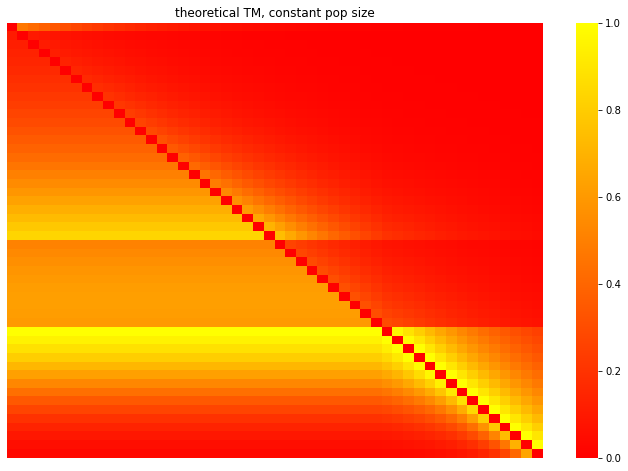

In [71]:
q_2_D, q_2_upper_D, q_2_lower_D, q_1_D, q_D = structuredsplit_abinitio(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2_D,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.5135006982344895


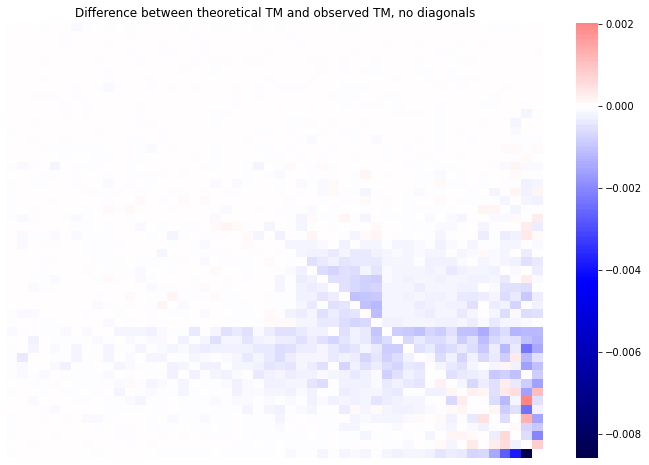

In [72]:
tm_2b = normalise(tm2b,'colsum')
diff_2D = q_D - tm_2b # theory minus observations
diff_2D_nd = np.copy(diff_2D)
diff_2D_nd = remove_diagonals(diff_2D_nd)

# heatmaps_div(diff_2D,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2D_nd,title="Difference between theoretical TM and observed TM, no diagonals")
# heatmaps_div_patch(diff_2D_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[20,17])

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2D)).sum()))


pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.42724803099624403


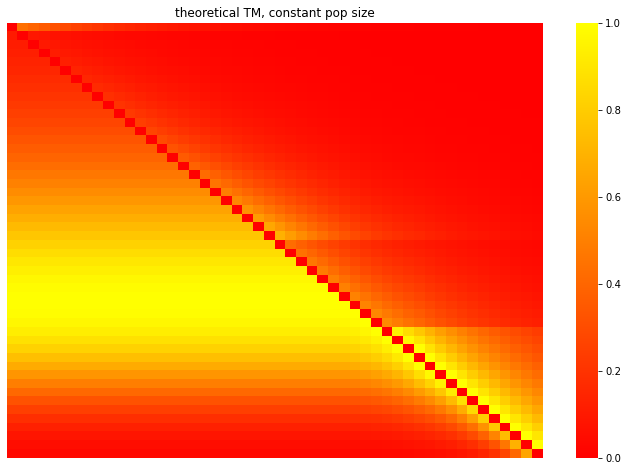

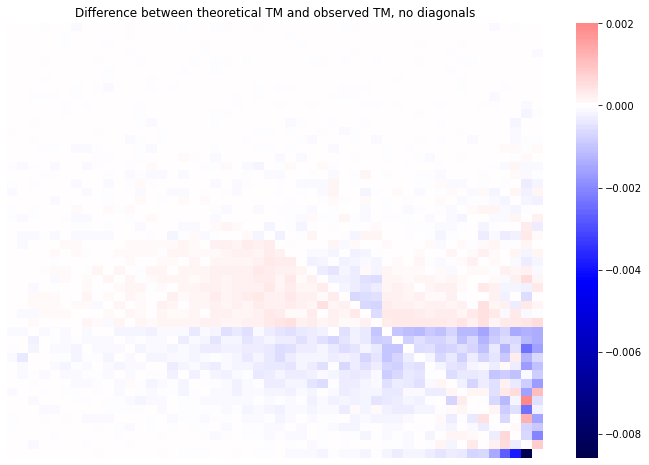

In [74]:
q_2_D, q_2_upper_D, q_2_lower_D, q_1_D, q_D = structuredsplit_abinitio_new(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2_D,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap

tm_2b = normalise(tm2b,'colsum')
diff_2D = q_D - tm_2b # theory minus observations
diff_2D_nd = np.copy(diff_2D)
diff_2D_nd = remove_diagonals(diff_2D_nd)

# heatmaps_div(diff_2D,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2D_nd,title="Difference between theoretical TM and observed TM, no diagonals")
# heatmaps_div_patch(diff_2D_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[20,17])

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2D)).sum()))



### Update from 22nd Feb

Have tried to have another thinkwith diagrams etc. See my powerpoint randomnotes.pptx.

This uses gamma^1 everywhere, which is what makes intuitive sense to me. 

In [100]:
def structuredsplit_abinitio_22ndfeb(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):
    # written 210217ymd
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    def sigma(int):
        sig = (1-gamma_array[int])**2 + (gamma_array[int])**2
        return sig
    def psis_finder(gamma_array):
        # find the first change in gamma (psi_s) and last change in gamma (psi_e)
        # for now, assume there is only one period of structure
        try:
            psi_s = np.where(gamma_array!=1)[0][0]
            psi_e = np.where(gamma_array!=1)[0][-1]
        except:
            psi_e = None
            psi_s = None
#             print('Psi is None')
        return psi_s, psi_e
    
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2

    def L(time1,time2):
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if ind1 == ind2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(T[ind1+1] - time1)*lambda_(ind1) - sum - (time2 - T[ind2])*lambda_(ind2))
        return L

    # flaggg
    
    def G(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            G = L(time1,time2)
        return G
    
    def G_B(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            sig = sigma(ind2)
            G = L(time1,time2)
        return G
    
    def G_C(time1,time2): # case C; bottom right corner
        # for when upper interval is higher than last structure occurence
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_e+1]:
            print('misunderstanding!')
        ind1, ind2 = lower_higher_intervals(time1,time2)
        sig = sigma(psi_s)
        gamma = gamma_array[psi_s]
        guess = 1
        if time1>=T[psi_e+1]:
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time1)
            G = G_upper/G_lower
            return G 
        elif time1>=T[psi_s] and time1<T[psi_e+1]:
#             G = ( (gamma)*L(time1,T[psi_e+guess]) + (1-gamma)*L(time1,T[psi_e+guess]) + 2*gamma*(1-gamma)) * L(T[psi_e+guess],time2) 
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],time1))
            G = G_upper/G_lower
            return G
        elif time1<T[psi_s]:
#             G = L(time1,T[psi_s]) * ( (gamma)*L(T[psi_s],T[psi_e+guess]) + (1-gamma)*L(T[psi_s],T[psi_e+guess]) + 2*gamma*(1-gamma)) * L(T[psi_e+guess],time2) 
            G_upper = L(0,T[psi_s])*(1-sig+sig*L(T[psi_s],T[psi_e+1]))*L(T[psi_e],time2)
            G_lower = L(0,time1)
            G = G_upper/G_lower
            return G
        else:
            print('there has been an error in G_post!')
        return G

    def G_4(time1,time2): # case 4, structured time to structured time
        # time2 necessarily will have time2>psi_s and time2<psi_e+1
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_s] or time2>T[psi_e+1]:
            print('problem! Misunderstanding in G_4')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*((
                    (gamma)*(L(T[psi_s],time2)) + ((1-gamma))*(L(T[psi_s],time2))
                )**2)
            elif time1>=T[psi_s]:
                G = ((gamma))*(L(time1,time2)**2) + (((1-gamma))*(L(time1,time2)**2)) 
        return G
    
    def H_4(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma + (1-gamma)))            
        else:
            print('misunderstanding in H_4!')
        return H
    
    def J_4(ind):
        J = (1/(2*lambda_(ind)))*((gamma + (1-gamma)))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def G_5(time1,time2): # case 5, post structured time to structured time
        # time2 necessarily will have time2>psi_s and time2<psi_e+1
        psi_s, psi_e = psis_finder(gamma_array)
        if time2>=T[psi_e+1]:
            print(f'problem! Misunderstanding in G_5. time2 is {time2} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*((
                    (gamma)*(L(T[psi_s],time2)) + ((1-gamma))*(L(T[psi_s],time2))
                )**2)
            elif time1>=T[psi_s]:
                G = ((gamma))*(L(time1,time2)**2) + (((1-gamma))*(L(time1,time2)**2)) 
        return G
    
    def H_5(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma + (1-gamma)))            
        else:
            print('misunderstanding in H_5!')
        return H
    
    def J_5(ind):
        J = (1/(2*lambda_(ind)))*((gamma + (1-gamma)))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def G_6(time1,time2): # case 6, post structured time to post structured time
        # time2 necessarily will have time2>psi_e 
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_e+1]:
            print(f'problem! Misunderstanding in G_6. time 2 is {time2}, T[psi_s] is {T[psi_s]} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*(( gamma*L(T[psi_s],T[psi_e+1]) + (1-gamma)*L(T[psi_s],T[psi_e+1]))**2) * (L(T[psi_e+1],time2)**2)
            elif time1>=T[psi_s] and time1<T[psi_e+1]:
                G = (( gamma*L(time1,T[psi_e+1]) + (1-gamma)*L(time1,T[psi_e+1]) )**2) * (L(T[psi_e+1],time2)**2)               
            elif time1>=T[psi_e+1]:
                G = (L(time1,time2)**2)
            else:
                print('Misunderstanding in G_6 !')
        return G
    
    def H_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s or ind>=psi_e+1:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s and ind<psi_e+1:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*(gamma+(1-gamma))
        else:
            print('misunderstanding in H_6!')
        return H
    
    def J_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        J = (1/(2*lambda_(ind)))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper4(alpha): 
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_4(j)*(G_4(T[j+1],T[alpha]))
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upper5(alpha): 
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_5(j)*(G_5(T[j+1],T[alpha]))
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper6(alpha): 
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_6(j)*(G_6(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperB(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_B(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperC(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_C(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                psi_s,psi_e = psis_finder(gamma_array)

                
                if alpha>=(psi_s) and alpha<=(psi_e+1) and beta>(psi_s) and beta<=(psi_e+1): # case 4, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) *( gamma + (1-gamma))*lambda_(alpha)  * (
                        q_2_upper4(alpha)*H_4(alpha) + J_4(alpha)
                                )
#                     q_2[alpha,beta] = 100                   

                elif alpha>=(psi_s) and alpha<(psi_e+1) and beta>=(psi_e+1): # case 5, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * (gamma+(1-gamma)) * (lambda_(alpha)) * ( # sometimes multiplying by sigma(alpha)**2 works well
                        q_2_upper5(alpha)*H_5(alpha) + J_5(alpha)
                                )
#                     q_2[alpha,beta] = 100

                elif alpha>=(psi_e+1) and beta>=(psi_e+1): # case 6; bottom right corner NEW
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                         q_2_upper6(alpha)*H_6(alpha) + J_6(alpha)
                                )
#                     q_2[alpha,beta] = 100

                else: # case 1, 2, or 3
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )       
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (G(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
#                 q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (sigma(alpha)**1)* (
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) *  (                  
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_


pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


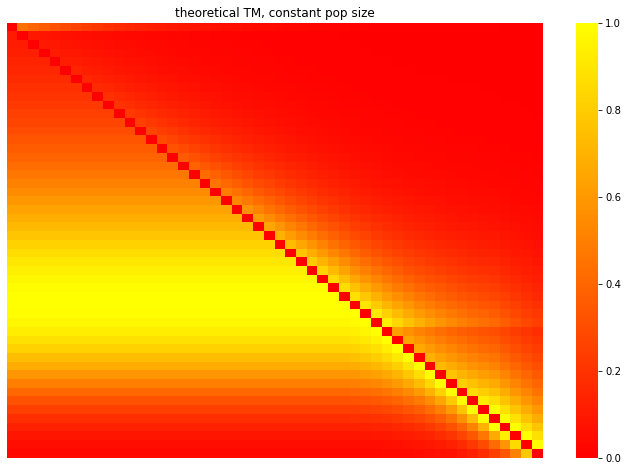

In [102]:
q_2_E, q_2_upper_E, q_2_lower_E, q_1_E, q_E = structuredsplit_abinitio_22ndfeb(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2_E,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap



/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.6647945092361026


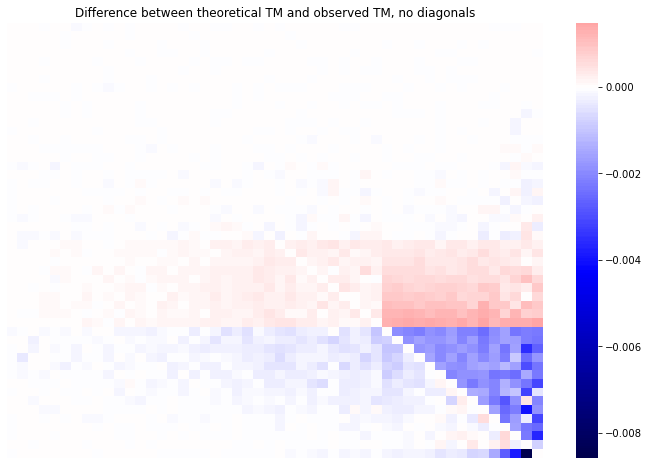

In [103]:
tm_2b = normalise(tm2b,'colsum')
diff_2E = q_E - tm_2b # theory minus observations
diff_2E_nd = np.copy(diff_2E)
diff_2E_nd = remove_diagonals(diff_2E_nd)

# heatmaps_div(diff_2E,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2E_nd,title="Difference between theoretical TM and observed TM, no diagonals")
# heatmaps_div_patch(diff_2E_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[20,17])

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2E)).sum()))


### Update from 23rd Feb

Have tried to have another thinkwith diagrams etc. See my powerpoint randomnotes.pptx . 

This uses gamma^2 everywhere.

In [108]:
def structuredsplit_abinitio_23rdfeb(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):
    # written 210217ymd
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    def sigma(int):
        sig = (1-gamma_array[int])**2 + (gamma_array[int])**2
        return sig
    def psis_finder(gamma_array):
        # find the first change in gamma (psi_s) and last change in gamma (psi_e)
        # for now, assume there is only one period of structure
        try:
            psi_s = np.where(gamma_array!=1)[0][0]
            psi_e = np.where(gamma_array!=1)[0][-1]
        except:
            psi_e = None
            psi_s = None
#             print('Psi is None')
        return psi_s, psi_e
    
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2

    def L(time1,time2):
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if ind1 == ind2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(T[ind1+1] - time1)*lambda_(ind1) - sum - (time2 - T[ind2])*lambda_(ind2))
        return L

    # flaggg
    
    def G(time1,time2):
        psi_s, psi_e = psis_finder(gamma_array)
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            G = L(time1,time2)
        return G
    

    def G_4(time1,time2): # case 4, structured time to structured time
        # time2 necessarily will have time2>psi_s and time2<psi_e+1
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_s] or time2>T[psi_e+1]:
            print('problem! Misunderstanding in G_4')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*((
                    (gamma**2)*(L(T[psi_s],time2)) + ((1-gamma)**2)*(L(T[psi_s],time2))
                )**2)
            elif time1>=T[psi_s]:
                G = ((gamma)**2)*(L(time1,time2)**2) + (((1-gamma)**2)*(L(time1,time2)**2)) 
        return G
    
    def H_4(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))            
        else:
            print('misunderstanding in H_4!')
        return H
    
    def J_4(ind):
        J = (1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def G_5(time1,time2): # case 5, post structured time to structured time
        # time2 necessarily will have time2>psi_s and time2<psi_e+1
        psi_s, psi_e = psis_finder(gamma_array)
        if time2>=T[psi_e+1]:
            print(f'problem! Misunderstanding in G_5. time2 is {time2} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*((
                    (gamma**2)*(L(T[psi_s],time2)) + ((1-gamma)**2)*(L(T[psi_s],time2))
                )**2)
            elif time1>=T[psi_s]:
                G = ((gamma)**2)*(L(time1,time2)**2) + (((1-gamma)**2)*(L(time1,time2)**2)) 
        return G
    
    def H_5(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))            
        else:
            print('misunderstanding in H_5!')
        return H
    
    def J_5(ind):
        J = (1/(2*lambda_(ind)))*((gamma**2 + (1-gamma)**2))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def G_6(time1,time2): # case 6, post structured time to post structured time
        # time2 necessarily will have time2>psi_e 
        psi_s, psi_e = psis_finder(gamma_array)
        if time2<T[psi_e+1]:
            print(f'problem! Misunderstanding in G_6. time 2 is {time2}, T[psi_s] is {T[psi_s]} and T[psi_e+1] is {T[psi_e+1]}')
        gamma = gamma_array[psi_s]
        ind1, ind2 = lower_higher_intervals(time1,time2)
        if psi_s is None:
            G = L(time1,time2)
        elif psi_s:
            if time1<T[psi_s]:
                G = (L(time1,T[psi_s])**2)*(( (gamma**2)*L(T[psi_s],T[psi_e+1]) + ((1-gamma)**2)*L(T[psi_s],T[psi_e+1]))**2) * (L(T[psi_e+1],time2)**2)
            elif time1>=T[psi_s] and time1<T[psi_e+1]:
                G = (( (gamma**2)*L(time1,T[psi_e+1]) + ((1-gamma)**2)*L(time1,T[psi_e+1]) )**2) * (L(T[psi_e+1],time2)**2)               
            elif time1>=T[psi_e+1]:
                G = (L(time1,time2)**2)
            else:
                print('Misunderstanding in G_6 !')
        return G
    
    def H_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        if ind<psi_s or ind>=psi_e+1:
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))
        elif ind>=psi_s and ind<psi_e+1:
            gamma = gamma_array[ind]
            H = (1-np.exp(-2*lambda_(ind)*delta(ind,T)))*(1/(2*lambda_(ind)))*(gamma**2+(1-gamma)**2)
        else:
            print('misunderstanding in H_6!')
        return H
    
    def J_6(ind):
        psi_s, psi_e = psis_finder(gamma_array)
        J = (1/(2*lambda_(ind)))*(delta(ind,T) - (1/(2*lambda_(ind)))*(1-np.exp(-2*lambda_(ind)*delta(ind,T))))
        return J
    
    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper4(alpha): 
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_4(j)*(G_4(T[j+1],T[alpha]))
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upper5(alpha): 
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_5(j)*(G_5(T[j+1],T[alpha]))
            sum_q = sum_q + iteration
        return sum_q

    def q_2_upper6(alpha): 
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = H_6(j)*(G_6(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperB(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_B(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    def q_2_upperC(alpha): # case B
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
#             iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_post(T[j+1],T[alpha])**2)
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(G_C(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                psi_s,psi_e = psis_finder(gamma_array)

                
                if alpha>=(psi_s) and alpha<=(psi_e+1) and beta>(psi_s) and beta<=(psi_e+1): # case 4, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) *( gamma**2 + (1-gamma)**2)*lambda_(alpha)  * (
                        q_2_upper4(alpha)*H_4(alpha) + J_4(alpha)
                                )
#                     q_2[alpha,beta] = 100                   

                elif alpha>=(psi_s) and alpha<(psi_e+1) and beta>=(psi_e+1): # case 5, from structure to structure section 
                    gamma = gamma_array[alpha]
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * (gamma**2+(1-gamma)**2) * (lambda_(alpha)) * ( # sometimes multiplying by sigma(alpha)**2 works well
                        q_2_upper5(alpha)*H_5(alpha) + J_5(alpha)
                                )
#                     q_2[alpha,beta] = 100

                elif alpha>=(psi_e+1) and beta>=(psi_e+1): # case 6; bottom right corner NEW
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                         q_2_upper6(alpha)*H_6(alpha) + J_6(alpha)
                                )
#                     q_2[alpha,beta] = 100

                else: # case 1, 2, or 3
                    q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )       
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (G(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
#                 q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (sigma(alpha)**1)* (
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) *  (                  
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_


pop_size is [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


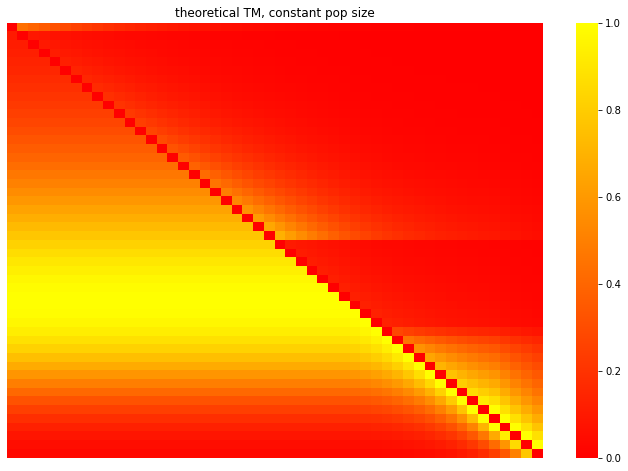

In [110]:
q_2_E, q_2_upper_E, q_2_lower_E, q_1_E, q_E = structuredsplit_abinitio_23rdfeb(T_np,50,pop_size2,gamma_array2,N_0,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2_E,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


total absolute differences in these matrics is 0.9192729933719288


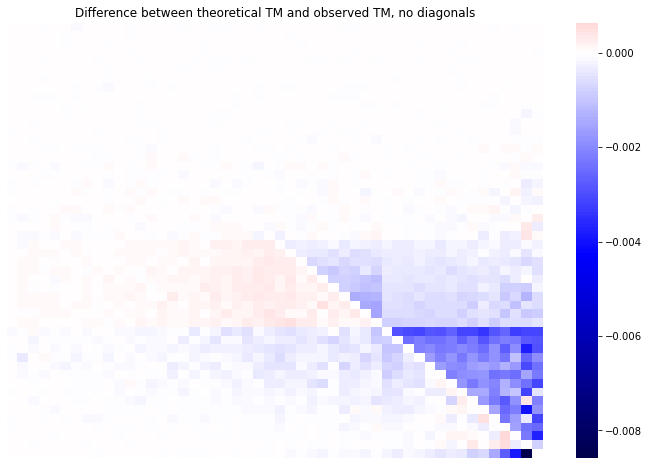

In [111]:
tm_2b = normalise(tm2b,'colsum')
diff_2E = q_E - tm_2b # theory minus observations
diff_2E_nd = np.copy(diff_2E)
diff_2E_nd = remove_diagonals(diff_2E_nd)

# heatmaps_div(diff_2E,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_2E_nd,title="Difference between theoretical TM and observed TM, no diagonals")
# heatmaps_div_patch(diff_2E_nd,title="Difference between (new) theoretical TM and observed TM, with diagonals",patch=[20,17])

print('total absolute differences in these matrics is {}'.format(sum(abs(diff_2E)).sum()))

